In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Discovering and forecasting extreme events via active learning in neural operators

Citation - Pickering, E., Guth, S., Karniadakis, G. E. & Sapsis, T. P. Discovering and forecasting extreme events via active learning in neural operators. Nat Comput Sci 2, 823–833 (2022).

## 2) MMT Nonlinear Wave

* We seek to map initially observed waves, $u(x, t = 0)$, where $x$ is the spatial variable and $t$ is time, to the QoI: the future spatial maximum $G(x) = ||Re(u(x, t = T; x))||_{\infty}$, where $T$ is a prescribed prediction horizon.
* MMT has complex solutions and therefore the ICs are also complex-valued.
* Dispersive nonlinear wave equation used for studying 1D wave turbulence.
$$
iu_{t} = |\partial_{x}|^{\alpha} u + \lambda |\partial_{x}|^{-\beta/4} \Big(||\partial_{x}|^{- \beta /4} u \Big|^{2} |\partial_{x}|^{- \beta /4} u \Big) + iDu,
$$
* where $u$ is a complex scalar, 
* exponents $\alpha$ and $\beta$ are chosen model parameters, 
* and $D$ is a selective Laplacian
* This model gives rise to four-wave resonant interactions that, especially when coupled with large scale forcing and small scale damping, produces a family of spectra revealing both direct and inverse cascades.
* Transform the equation into wavenumber space.
* The pseudodifferential operator $|\partial_{x}|^{\alpha}$, via the Fourier transform in space becomes: $\widehat{|\partial_{x}|^{\alpha} u(k)} = |k|^{\alpha} \widehat{u} (k)$ where $k$ is the wavenumber in $x$. 
* This formulation may be similarly defined on a periodic domain. 
* We choose $\alpha = 1/2$ and $\beta = 0$. Above equation reduces to
$$
\hat{u}(k)_{t} = -i |k|^{1/2} \hat{u} (k) - i \lambda |\hat{u} (k)|^{2} \hat{u} (k) + \widehat{Du}(k) + f(k)
$$
* where $f(k)$ is a forcing and $\widehat{Du}(k)$ is a selective Laplacian of the form:
$$
\widehat{Du}(k) = 
\begin{cases}
  -(|k| - k^{*})^2 \hat{u} k, & |k|>k^{*} \\
  0, & |k| \leq k^{*} \\
\end{cases}
$$
* where $k^{*}$ presents the lower bound of wavenumbers subject to dissipation.
* For the model considered in this study we choose $\lambda = −0.5, k^{*} = 20, f (k) = 0, dt = 0.001$, and a grid that is periodic between $0-1$ with $N_x = 512$ grid points.
* To propose a stochastic and complex initial condition, $u(x, t = 0)$, we take the complex-valued kernel
$$
k(x,x') = \sigma^{2}_{u} e^{i(x-x')} e^{-\frac{(x-x')^{2}}{\ell_{u}}}
$$
* with $\sigma^{2}_{u} = 1$ and $\ell_{u} = 0.35$.
* We then parametrize the stochastic initial conditions by a finite number of random variables, $x$, using the Karhunen-Loeve expansion of the kernel’s correlation matrix,
$$
u(x,t = 0) \approx \textbf{x} \Phi(x), \space \forall \space x \in [0,1)
$$
* where $x \in \mathbb{C}^m$ is a vector of complex coefficients and both the real and imaginary components of each coefficient are normally distributed with zero mean and diagonal covariance matrix $\Lambda$.
* and $\{\Lambda, \Phi (x)\}$ contains the first $m$ eigenpairs of the correlation matrix.
* This gives the dimension of the parameter space as $2m$ to account for the real and imaginary components of each coefficient. 
* The presented $2D, 4D, 6D, 20D$ results correspond to $m = 1, 2, 3, 10$. 
* For all cases, the random variable $x_i$ is restricted to a domain ranging from -6 to 6, in that 6 standard deviations in each direction from the mean.

In [2]:
from utils.blackbox import BlackBox
from utils.complex_noise import Noise_MMT
from utils.gaussian_input import GaussianInputs
import scipy.io as sio

seed = 1
iter_num = 1
rank = 1
n_init = 3
init_method = "lhs"
acq = "US_LW"
lam = 0.5
N = 2
batch_size = 1
model = "DON"
epochs = 1000
b_layers=5
t_layers=1
neurons=200
# n_guess=1
# objective='MaxAbsRe' #'MaxAbsRe'

In [3]:
tf = 1

noise = Noise_MMT([0, tf], rank)

In [4]:
from data.data_functions import map_def, Save_U

if iter_num == 0:
        ndim = rank*2
        np.random.seed(seed)
        noise_var = 0
        nsteps = 512
        my_map = BlackBox(map_def, noise_var=noise_var)

        mean, cov = np.zeros(ndim), np.ones(ndim)
        domain = [ [-6, 6] ] * ndim
        inputs = GaussianInputs(domain, mean, cov)
        Theta = inputs.draw_samples(n_init, init_method)
        
        save_y0_file = './data/'+'_Seed'+str(seed)+'_ndim'+str(ndim)+'_rank'+str(rank)+'_n_init'+str(n_init)+'_init_method_'+str(init_method)+'_savedata_y0.mat'

        y0 = np.zeros((nsteps,n_init),dtype=np.complex_)
        for i in range(0,n_init):
            y0[:,i] = Save_U(Theta[i,:],noise,nsteps,rank).reshape(nsteps,)
            # Save the y0 file to run with matlab
        sio.savemat(save_y0_file, {'y0':y0, 'Theta':Theta})        
else:
    ndim = rank*2
    np.random.seed(seed)
    noise_var = 0
    my_map = BlackBox(map_def, noise_var=noise_var)

    mean, cov = np.zeros(ndim), np.ones(ndim)
    domain = [ [-6, 6] ] * ndim
    inputs = GaussianInputs(domain, mean, cov)
    
    # Need to determine U
    nsteps = 512 # Reset the number of steps for deeponet
    x_vals = np.linspace(0, 1, nsteps+1)
    x_vals = x_vals[0:-1]
        
    #Y = my_map.evaluate(Theta,1)    
    coarse = 4

    save_path_data_prev = './results/Rank'+str(rank)+'_'+model+'_'+acq+'_Seed'+str(seed)+'_N'+str(N)+'_Batch_'+str(batch_size)+'_Init_'+init_method+'_Iteration'+str(iter_num-1)+'.mat'
    load_Y_file = './data/IC/Rank'+str(rank)+'_'+model+'_Seed'+str(seed)+'_Acq'+acq+'_Iter'+str(iter_num-1)+'_Lam'+str(lam)+'_BatchSize'+str(batch_size)+'_N'+str(N)+'_savedata_Y.mat' 
    save_y0_file_prev = './data/IC/Rank'+str(rank)+'_'+model+'_Seed'+str(seed)+'_Acq'+acq+'_Iter'+str(iter_num-1)+'_Lam'+str(lam)+'_BatchSize'+str(batch_size)+'_N'+str(N)+'_savedata_y0.mat'       

    if iter_num == 1:
            # d = sio.loadmat(save_y0_file_prev)
            d = sio.loadmat("/Users/rohan/Documents/DeepONet Datasets/Extreme Events Dataset/MMT Nonlinear Wave Model/data/_Seed1_ndim2_rank1_n_init3_init_method_lhs_savedata_y0.mat")
            Theta = d['Theta']
            # d = sio.loadmat(load_Y_file)
            d = sio.loadmat("/Users/rohan/Documents/DeepONet Datasets/Extreme Events Dataset/MMT Nonlinear Wave Model/nls/Rank1_from_code_provided/Rank1_DON_US_LW_Seed1_N2_Iteration1.mat")
            Y = d['Y']
            print(np.shape(Y))
            
    else: 
        d = sio.loadmat(save_path_data_prev)
        Theta = d['Theta']
        Y = d['Y']
    
        # Load in the files
        d = sio.loadmat(save_y0_file_prev)
        theta_opt = d['theta_opt']
        d = sio.loadmat(load_Y_file)
        Y_opt = d['Y']
    
        Theta = np.vstack((Theta, theta_opt))
        Y = np.vstack((Y, Y_opt))
        print(np.shape(Theta))
        print(np.shape(Y))

(3, 1)


In [5]:
from data.data_functions import Theta_to_U, Theta_to_Z, DNO_Y_transform
# Transform to U and G values
       
u_train = Theta_to_U(noise,Theta,nsteps,coarse,rank)
print(f"Shape of u_train:{u_train.shape}")
y_train = Theta_to_Z(Theta,rank)
print(f"Shape of y_train:{y_train.shape}")
G_train = DNO_Y_transform(Y)
print(f"Shape of G_train:{G_train.shape}")

Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


 /Users/rohan/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning:Casting complex values to real discards the imaginary part


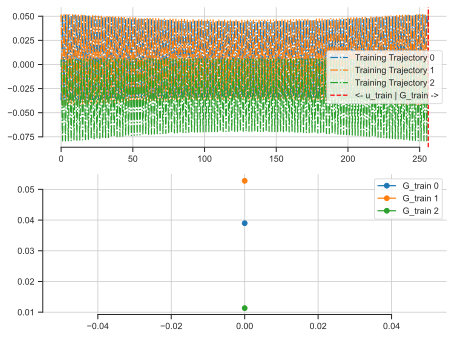

In [6]:
n_datapoints = u_train.shape[1]
separation_idx = n_datapoints

fig,(ax1,ax2) = plt.subplots(2,1)

for row in range(n_init):
    ax1.plot(np.concatenate((u_train[row], G_train[row]), axis=0), "-." ,label = f"Training Trajectory {row}")
    ax2.plot(G_train[row], "-o", label = f"G_train {row}")
ax1.axvline(x=separation_idx, color='r', linestyle='--', label="<- u_train | G_train ->")
ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()

plt.tight_layout()
sns.despine(trim=True)
plt.show()

In [7]:
import deepxde as dde

m       = int(nsteps/coarse*2) #604*2
lr      = 0.001
dim_x   = 1
activation = "relu"
branch      = [neurons]*(b_layers+1)
branch[0]   = m
trunk       = [neurons]*(t_layers+1)
trunk[0]    = dim_x

net = dde.maps.DeepONet(
    branch,
    trunk,
    activation,
    "Glorot normal",
    # use_bias=True,
    # stacked=False,
)
print(net)
save_period = epochs

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


DeepONet(
  (branch): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=256, out_features=200, bias=True)
      (1-4): 4 x Linear(in_features=200, out_features=200, bias=True)
    )
  )
  (trunk): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=200, bias=True)
    )
  )
  (b): ParameterList(  (0): Parameter containing: [torch.float32 of size ])
)


In [8]:
from supervisor.supervisor import DeepXDE_DeepONet

# Train the model
np.random.seed(np.size(Y)) # Randomize the seed based on Y size for consistency
# Where to save the DeepONet models
model_dir = './'
model_str = 'Rank'+str(rank)+'_'+model+'_'+acq+'_Seed'+str(seed)+'_N'+str(N)+'_Batch_'+str(batch_size)+'_Init_'+init_method
model = DeepXDE_DeepONet(Theta, noise, nsteps, Y, net, lr, epochs, N, 
                         model_dir, seed, save_period, model_str, coarse, rank)

Compiling model...


 /Users/rohan/Documents/DeepONet Datasets/Extreme Events Dataset/MMT Nonlinear Wave Model/supervisor/supervisor.py:26: ComplexWarning:Casting complex values to real discards the imaginary part


'compile' took 5.405256 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.67e-03]    [2.32e-03]    [2.32e-03]    
1000      [1.19e-17]    [1.39e-17]    [1.39e-17]    

Best model at step 1000:
  train loss: 1.19e-17
  test loss: 1.39e-17
  test metric: [1.39e-17]

'train' took 19.897885 s

Compiling model...
'compile' took 0.000504 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.19e-17]    [1.39e-17]    [1.39e-17]    
1000      [4.16e-17]    [5.55e-17]    [5.55e-17]    

Best model at step 0:
  train loss: 1.19e-17
  test loss: 1.39e-17
  test metric: [1.39e-17]

'train' took 7.866366 s

